# **Compression & Rerank**

Welcome to Advanced RAG. Here, I want to tackle the issue of ensuring only a few VERY RELEVANT chunks are sent to the generator LLM, and also to not fill up the context window.

**Architecture**:

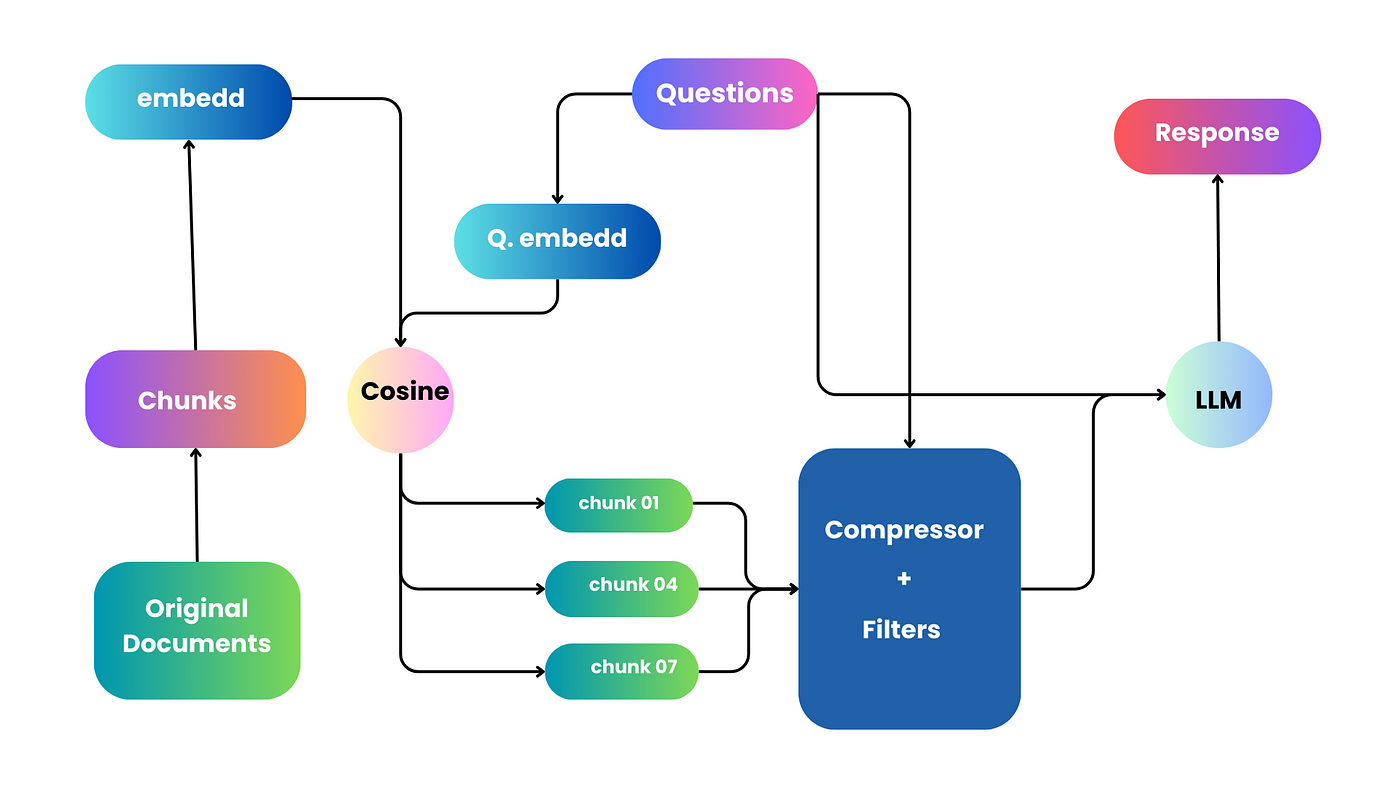

Load environment keys:

In [28]:
from dotenv import load_dotenv
load_dotenv()

True

Download the document:

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

Run the retrieval pipeline:

In [30]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\klopp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## **Advanced RAG**

In order to improve upon the quality and relevance of the context that gets sent to the generator, I have decided to perform compression of those retrieved documents, and re-ranking. Luckily, LangChain has some python integrations that make performing re-ranking as easy as a few lines of code. For this notebook, I will be using Cohere. You can read more: [**Cohere & Re-Rankers**](https://python.langchain.com/docs/integrations/retrievers/cohere-reranker).



In [31]:
# Uncomment and run code below if you don't have langchain_cohere already installed
#! pip install --upgrade --quiet  langchain-cohere 

Let me create a compressed retriever that reranks the returned chunks.

In [32]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

In [33]:

compressor = CohereRerank(top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

You could try [**Flashrank**](https://python.langchain.com/docs/integrations/retrievers/flashrank-reranker/) at zero costs incurred. It requires no API calls so no call limits. Simply uncomment and run code blocks below:

In [34]:
# !pip install --quiet --upgrade flashrank

In [35]:
#from langchain.retrievers import ContextualCompressionRetriever
#from langchain.retrievers.document_compressors import FlashrankRerank


#compressor = FlashrankRerank(top_n=5)
#compression_retriever = ContextualCompressionRetriever(
#    base_compressor=compressor, base_retriever=retriever)

 Helper function for printing docs:

In [36]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [38]:
# query = "what are macronutrients?"
#compressed_docs = compression_retriever.invoke(question)
compressed_docs = compression_retriever.get_relevant_documents(
    input("Your query: ")
)
pretty_print_docs(compressed_docs)

Document 1:

Macronutrients 
Nutrients 
that 
are 
needed 
in 
large 
amounts 
are 
called 
macronutrients. There are three classes of macronutrients: 
carbohydrates, lipids, and proteins. These can be metabolically 
processed into cellular energy. The energy from macronutrients 
comes from their chemical bonds. This chemical energy is 
converted into cellular energy that is then utilized to perform work, 
allowing our bodies to conduct their basic functions. A unit of
----------------------------------------------------------------------------------------------------
Document 2:

description of these macronutrients; they are also known 
colloquially as the “workhorses” of life. Proteins provide four 
kilocalories of energy per gram; however providing energy is not 
protein’s most important function. Proteins provide structure to 
bones, muscles and skin, and play a role in conducting most of the 
chemical reactions that take place in the body. Scientists estimate 
that greater than on

Just 3 chunks returned now. Great, no more issues with stuffing. I think I can find this document 1 manually in the PDF:

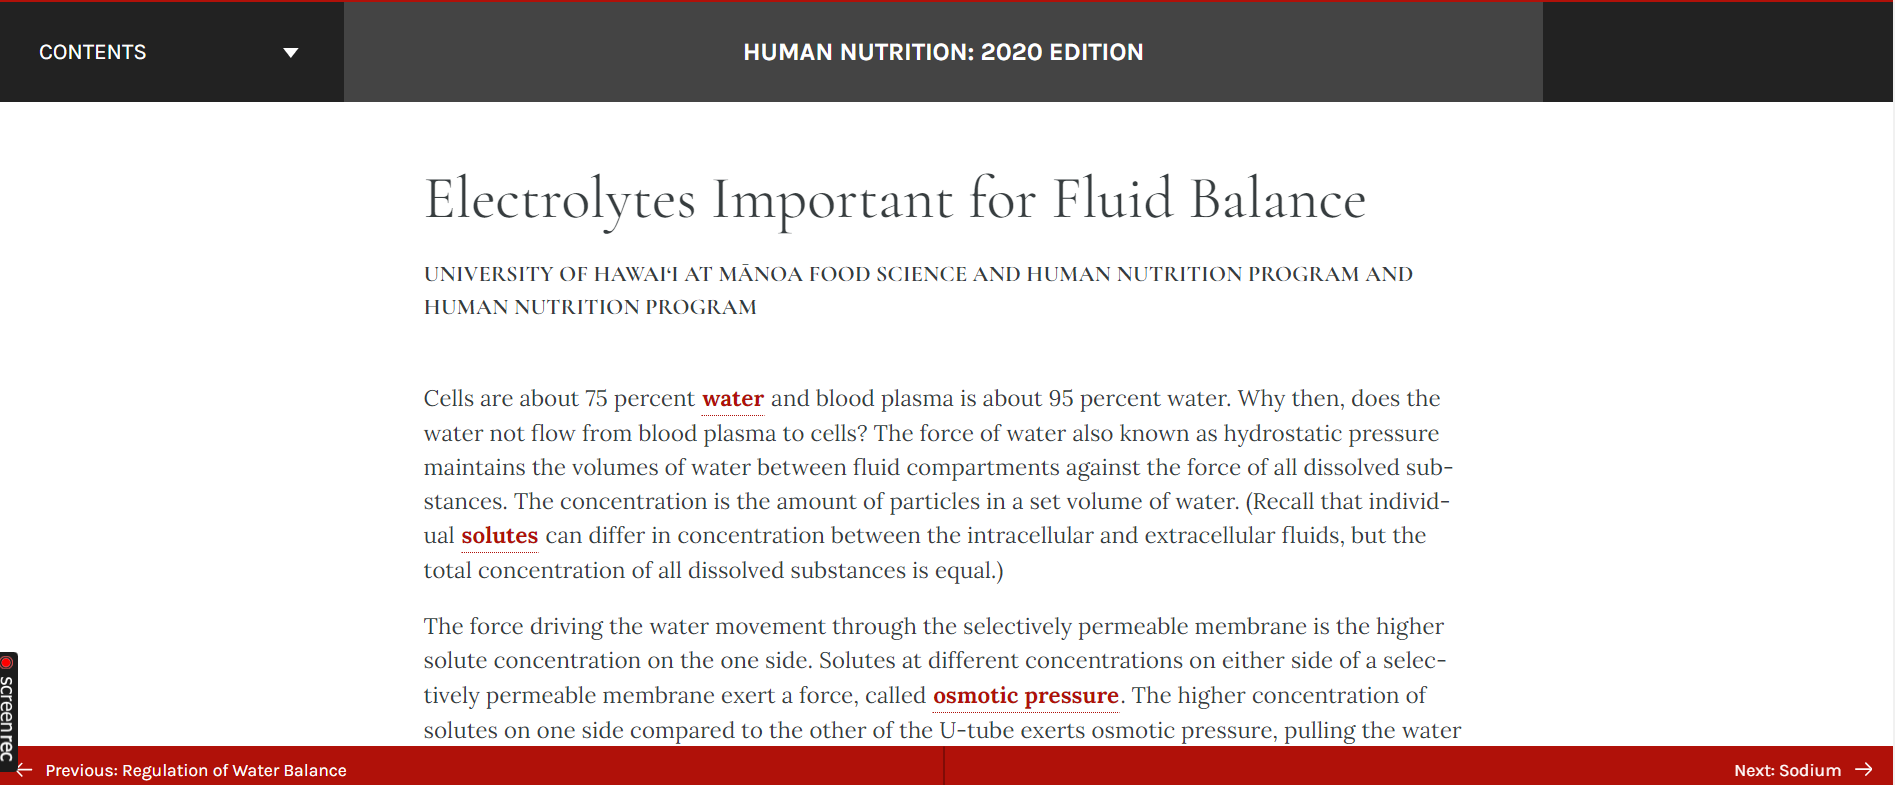

Great! Now, let me enhance the *feel* of the conversation. I want to incorporate a memory component for the system to remember previous conversation threads. This time, instead of using a simple ready-made chain with prebuilt functions, I will utilize a runnable interface with a language protocol known as LCEL to build custom chains tailored to my preferences. Here’s why:

* Having the tools and components to build your chain offers more flexibility compared to a prebuilt chain. This allows you to compose the components of your chain in any manner you prefer, whether sequential, parallel, or otherwise.
* Often, we are overwhelmed by these prebuilt functions and may forget where to import them from. With LCEL, you can completely replace the **RetrievalQA** chain by chaining "the LLM" and "the user prompt" together using this operator "|" like so:    **prompt | llm.**


Now, let me implement this. I will take my current application apart and build custom components and runnables.

##### LangChain Expression Language (LCEL)

LCEL is a protocol that makes it easier to compose chains and components together and encourages parallel execution of steps thus reducing processing time. LCEl also converts prototypes into production-ready pipelines.

In [40]:
from typing import List
from operator import itemgetter

from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables.history import RunnableWithMessageHistory

In [41]:
from langchain_core.output_parsers import StrOutputParser
from langchain_cohere import ChatCohere

llm = ChatCohere(model="command-r", temperature=0)


# LLM

llm = llm

# define conversation memory as a class
class InMemoryHistory(BaseChatMessageHistory, BaseModel):
    """In memory implementation of chat message history."""

    messages: List[BaseMessage] = Field(default_factory=list)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add a list of messages to the store"""
        self.messages.extend(messages)

    def clear(self) -> None:
        self.messages = []

# Use a global variable to store the chat message history.
store = {}

def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryHistory()
    return store[session_id]

Trying out a little prompt engineering:

In [42]:
# prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You're a Chatbot."),
    MessagesPlaceholder(variable_name="history"),
    ("human", "Given this history: {history} and \n this context:\n{context}\n, answer this question below\nQuestion:{query}. \
        by strictly following this instruction: Answer the question based only on the history and context and nothing else. If asked about unrelated topics, simply provide the relevant information from the context. \
        If you don't know the answer based on history and context provided, only say - I don't know. \
        If asked about your emotions or feelings, only say - As an AI language model, I lack the ability to formulate feelings or emotions. \
        Reply in only one sentence and keep the answer concise."),
])

In [43]:
# chain components together 
output_parser = StrOutputParser()
retriever = compression_retriever
retrieval_chain = (
    {"context": itemgetter("query") | retriever,
        "query": itemgetter("query"),
        "history": itemgetter("history")}
    | RunnableParallel ({
    "output": prompt | llm | StrOutputParser(),
    "context": itemgetter("context") # This adds the retrieved context as well to the chain
})
)

import logging
# hide warning log
logging.getLogger().setLevel(logging.ERROR) 

retrieval_chain_with_history = RunnableWithMessageHistory(
    retrieval_chain,
    # Uses the get_by_session_id function defined in the example
    # above.
    get_by_session_id,
    input_messages_key="query",
    history_messages_key="history",

)


Inspect:

In [44]:
# query = "What is this knowledge base?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
print(result["output"])
print("-"*50)
provided_context = ' '.join(document.page_content for document in result['context'])
print(f"Context sent to the model: {provided_context}")

This knowledge base contains information on the 2020 edition of a Human Nutrition textbook.
--------------------------------------------------
Context sent to the model: other internal material which may aid in understanding topics and 
concepts, intra-text links to the appendices and glossary for tables 
and definitions of words, and extra-text links to videos and web 
material that clarifies and augments topics and concepts. 
xlii  |  Acknowledgements features interactive learning activities.  These activities are 
available in the web-based textbook and not available in the 
downloadable versions (EPUB, Digital PDF, Print_PDF, or 
Open Document). 
Learning activities may be used across various mobile 
devices, however, for the best user experience it is strongly 
recommended that users complete these activities using a 
desktop or laptop computer and in Google Chrome. 
 
An interactive or media element has been Building a protein involves three steps: transcription, translation, 
De

In [45]:
# query = "what are macronutrients?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
response = result['output']
print(response)

Macronutrients are nutrients needed in large amounts and can be metabolically processed into cellular energy.


In [ ]:
#print(result['context'])

In [46]:
provided_context = ' '.join(document.page_content for document in result['context'])
print(f"Context sent to the model: {provided_context}")

Context sent to the model: Macronutrients 
Nutrients 
that 
are 
needed 
in 
large 
amounts 
are 
called 
macronutrients. There are three classes of macronutrients: 
carbohydrates, lipids, and proteins. These can be metabolically 
processed into cellular energy. The energy from macronutrients 
comes from their chemical bonds. This chemical energy is 
converted into cellular energy that is then utilized to perform work, 
allowing our bodies to conduct their basic functions. A unit of description of these macronutrients; they are also known 
colloquially as the “workhorses” of life. Proteins provide four 
kilocalories of energy per gram; however providing energy is not 
protein’s most important function. Proteins provide structure to 
bones, muscles and skin, and play a role in conducting most of the 
chemical reactions that take place in the body. Scientists estimate 
that greater than one-hundred thousand different proteins exist energy, 
to 
digesting 
nutrients, 
to 
building 
macrom

In [47]:
# query = "and what are those needed in small quantities called?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
print(result["output"])
print("-"*50)
provided_context = ' '.join(document.page_content for document in result['context'])
print(f"Context sent to the model: {provided_context}")

Those needed in small quantities are called trace minerals.
--------------------------------------------------
Context sent to the model: classified depending on how much of them we need. Trace minerals, 
such as molybdenum, selenium, zinc, iron, and iodine, are only 
required in a few milligrams or less. Macrominerals, such as calcium, 
magnesium, potassium, sodium, and phosphorus, are required in 
hundreds of milligrams. Many minerals are critical for enzyme 
Introduction  |  9 three hundred used during food processing today. The most popular 
additives are benzoates, nitrites, sulfites, and sorbates, which 
prevent molds and yeast from growing on food.2 Food additives 
1. Sugar and Carbohydrates. American Heart Association. 
http:/
/www.heart.org/HEARTORG/GettingHealthy/
NutritionCenter/HealthyDietGoals/Sugars-and-
Carbohydrates_UCM_303296_Article.jsp#. Updated 
April 20, 2017. Accessed January 4, 2018. 
2. The Dangers of Food Additives. How Stuff Works. 
http:/ the sufficient intak

In [48]:
# query ="Is today wednesday?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
print(result["output"])
print("-"*50)
provided_context = ' '.join(document.page_content for document in result['context'])
print(f"Context sent to the model: {provided_context}")

I don't know.
--------------------------------------------------
Context sent to the model: several days per week. The resulting improvements in body 
composition will go a long way toward providing greater protection 
against falls and fractures, and helping to ward off cardiovascular 
disease and hypertension, among other chronic conditions.9 
It Too Late to Improve Our Health through Nutrition?. 
American Journal of Clinical Nutrition, 86, 1572S–6S. 
9. Rivlin, RS. (2007). Keeping the Young-Elderly Healthy: Is 
It Too Late to Improve Our Health through Nutrition?. long as they are consumed within the same day, you will meet your 
protein needs. 
Table 6.4 Complementing Protein Sources the Vegan Way 
Proteins, Diet, and Personal Choices  |  415 MC00023. Accessed February 21, 2012. 
786  |  Pregnancy


In [ ]:
# query = "why are electrolytes important in the body?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
print(result["output"])
print("-"*50)
provided_context = ' '.join(document.page_content for document in result['context'])
print(f"Context sent to the model: {provided_context}")

Electrolytes help maintain fluid balance and a constant pH in the body, which is crucial for the body's healing process.
--------------------------------------------------
Context sent to the model: the sodium lost in sweat and promotes fluid uptake in the small 
intestine, improving hydration. 
In this chapter we will discuss the importance and functions of 
fluid and electrolyte balance in the human body, the consequences 
of getting too much or too little of water and electrolytes, the best 
dietary sources of these nutrients, and healthier beverage choices. 
After reading this chapter you will know what to look for in sports water. Three electrolytes are more closely regulated than others: 
Na+, Ca++, and K+. The kidneys share pH regulation with the lungs 
and plasma buffers, so that proteins can preserve their three-
dimensional conformation and thus their function. 
Learning Activities 
Technology Note: The second edition of the Human 
Nutrition Open Educational Resource (OER) te

In [50]:
# query = "Hi, how are you?"
result = retrieval_chain_with_history.invoke({"query": input("Your query: ")},
    config={"configurable": {"session_id": "foo"}})
print(result["output"])

As an AI language model, I lack the ability to formulate feelings or emotions.


Notice how the output is readable now in just a simple line? That is what StrOutputParser() does for you, in case you are wondering. There is also SimpleJSONOutputParser() for a JSON output.

Not bad. Now, i could test SOTA (state-of-the-art) models at this point, like the [**OpenAI models**](https://platform.openai.com/docs/models). 

Anyway, I will move on to even better RAG techniques involving *Function-calling*, *tools*, and *agents* sometimes known as *Agentic RAG*. I will begin with Adaptive RAG; an advanced RAG technique which combines other agentic techniques like *Self RAG* and *Corrective RAG* together.